In [1]:
from typing import List, Optional
from autograd import grad, jacobian, elementwise_grad
import autograd.numpy as np
import matplotlib.pyplot as plt
import sys, os
from tqdm import tqdm
import math
import scipy 
from scipy import linalg
from numpy import linalg as LA
from pyblas.level1 import dnrm2

sys.path.insert(0, os.path.join(".."))
%load_ext autoreload
%autoreload 2

In [3]:
from lib import problems as pr
from lib import optimisers as opt
from lib import utils as ut

**Data generation**

In [4]:
sys.path.insert(0, os.path.join("..", "tdlearn"))

In [5]:
sys.path.insert(0, os.path.join("..", "tdlearn", "util"))

In [6]:
# repo from https://github.com/chrodan/tdlearn
from tdlearn import examples
from tdlearn import features
from tdlearn import policies

In [7]:
n = 400 # |S|
n_a = 10
n_feat = 200 # d
mdp = examples.RandomMDP(n, n_a)
phi = features.lin_random(n_feat, n, constant=True)
gamma = .95
np.random.seed(3)
beh_pol = policies.Discrete(np.random.rand(n, n_a))
tar_pol = policies.Discrete(np.random.rand(n, n_a))

In [8]:
from task import LinearDiscreteValuePredictionTask

task = LinearDiscreteValuePredictionTask(mdp, gamma, phi, np.zeros(phi.dim),
                                         policy=beh_pol, target_policy=tar_pol)

In [9]:
Phi = task.Phi

In [62]:
_C = np.zeros((n_feat, n_feat))
for s in range(n):
    _C += Phi[s].T.dot(Phi[s])

In [64]:
_C

array([[132.3901114 ,  97.76274183, 102.33712169, ..., 101.92788541,
         97.90852101, 198.62850564],
       [ 97.76274183, 133.84740882, 105.41928405, ..., 103.89166623,
        101.36922797, 199.80451165],
       [102.33712169, 105.41928405, 140.99246525, ..., 106.10621796,
        107.04401561, 207.82468526],
       ...,
       [101.92788541, 103.89166623, 106.10621796, ..., 138.4972571 ,
        103.59722151, 203.98860115],
       [ 97.90852101, 101.36922797, 107.04401561, ..., 103.59722151,
        138.57030077, 204.7450469 ],
       [198.62850564, 199.80451165, 207.82468526, ..., 203.98860115,
        204.7450469 , 400.        ]])

In [54]:
C = np.tensordot(Phi[:, None, :], Phi[..., None], axes=([0,1], [0,2]))

In [67]:
np.isclose(C,_C).all()

True

In [10]:
_states, _actions, _n_states, _rewards = [], [], [], []
for s, a, _s, r in task.mdp.sample_transition(max_n=n, policy=beh_pol, seed=None,
                                    with_restart=True, s_start=None):
    _states.append(s)
    _actions.append(a)
    _n_states.append(_s)
    _rewards.append(r)

In [11]:
C = np.tensordot(Phi[_states, None, :], Phi[_states, :, None], axes=([0,1], [0,2]))

In [12]:
b = np.asarray(np.array(_rewards).dot(Phi[_states, :]))

In [13]:
B = C - gamma*np.tensordot(Phi[_states, None, :], 
                           Phi[np.hstack([_states[1:], _states[-1]]), :, None], axes=([0,1], [0,2]))

In [26]:

import lib.utils as ut



class RL_problem(pr.BaseSaddle):
    def __init__(self, B, C, b):
        L_xy = 1
        mu_xy = 0.25
        mu_yx = 0.25
        A = -2*B
        super().__init__(A=A)
        self.A = A
        spectrum = LA.svd(self.A.T.dot(self.A))[1]
        self.L_xy = spectrum.max()**.5
        self.mu_yx = spectrum.min()**.5 
        self.mu_xy = LA.svd(self.A.dot(self.A.T))[1].min()
        self.C = C
        self.b = b
        n = self.A.shape[0]
        
        self.f = lambda x, y: 0.5*x.transpose() @ x
        self.g = lambda x, y:  y.transpose() @ self.C @ y - self.b.transpose() @ y
        self.L_x = 1
        self.mu_x = 1
        
        spectrum = LA.svd(self.C.T.dot(self.C))[1]
        self.L_y = spectrum.max()**.5
        self.mu_y = spectrum.min()**.5 
        # self.mu_xy = sla.svd(self.C.dot(self.C.T))[1].min()
        
        self.xopt = LA.solve(self.A.transpose(), np.zeros((n, 1)))
        self.yopt = LA.solve(self.A, np.zeros((n, 1))) 
        self.constraint=False   
        self.dfdx = grad(self.f)
        self.dfdy = 0  
        self.dgdx = 0
        self.dgdy = grad(self.g, 1)  
        self.d2fdxdx = grad(self.dfdx)
        self.d2fdydy = grad(self.dfdy, 1)
        self.d2fdxdy = grad(self.dfdx, 1)
        self.d2fdydx = grad(self.dfdy)

In [51]:
problem_RL = RL_problem(B=B,C=C, b=b.T)
params = {'apdg': None,
          'altgd': 0.1,
          'AA': 0.5
         }
 # {'simgd':0.05, 'altgd':0.1, 'avg':1, 'adam':0.01, 'eg':0.6,'omd':0.3, 'fr':0.05,'AA':0.5}

x0 = np.ones(n_feat, )
y0 = np.ones(n_feat, )
type2=True
iteration = 100
k =  10
loss_f3, xpath_f3, ypath_f3 = ut.main(problem_RL, iteration, x0.copy(), y0.copy(), params, k=k)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 344.11it/s]
C:\Users\Georgy\Anaconda3\envs\pytorch_env\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Georgy\Anaconda3\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in matmul
C:\Users\Georgy\Anaconda3\envs\pytorch_env\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
C:\Users\Georgy\Anaconda3\envs\pytorch_env\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in add
  return f_raw(*args, **kwargs)
C:\Users\Georgy\Anaconda3\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in matmul
..\lib\problems.py:28: RuntimeWarning: overflow encountered in matmul
  self.F = lambda x, y: self.f(x, y) + x.T @

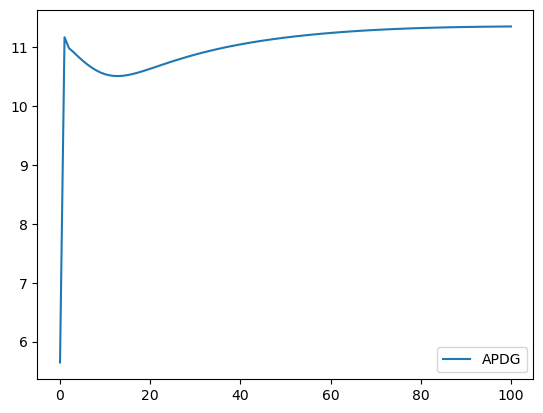

In [53]:
%matplotlib inline
import numpy as np
plt.plot(np.log(loss_f3[0]), label="APDG")
# plt.plot(np.log(loss_f3[1]), label="AltGD")
plt.legend()

In [50]:
ut.display_constants(problem_RL)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [42]:
1 - max()

4.418265688782324e-10